# 03 – Model Interpretation & Explainability

### CMSE 492 — Building Electricity Usage & Building Characteristics

This notebook focuses on explaining the models developed in Notebook 2. Using the building level dataset, I apply feature importance techniques, permutation importance, and SHAP values to understand which building characteristics most strongly influence electricity usage. This interpretation step is essential for drawing actionable insights from the model and identifying drivers of energy consumption across campus buildings.


### Load Cleaned Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.15)

# Load the small, modeling-ready dataset (exported from Notebook 2)
model_df = pd.read_csv("../data/processed/building_level_model_df.csv")

model_df.head()



,building_id,mean_electricity,building_age,sqft,primaryspaceusage,energy_intensity,log_mean_electricity,age_bin
0,Bear_assembly_Angel,494.336396,91.0,238065.0,Entertainment/public assembly,0.002076,6.205237,75+
1,Bear_assembly_Beatrice,42.962056,66.0,30160.0,Entertainment/public assembly,0.001424,3.783327,51–75
2,Bear_assembly_Danial,160.655729,8.0,82670.0,Entertainment/public assembly,0.001943,5.085469,0–25
3,Bear_assembly_Diana,0.856884,29.0,1305.0,Entertainment/public assembly,0.000657,0.618900,26–50
4,Bear_assembly_Genia,261.089054,101.0,261091.0,Entertainment/public assembly,0.001000,5.568684,75+


### Sanity check

In [23]:
model_df.info()
model_df.describe(include='all')
model_df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   building_id           755 non-null    object 
 1   mean_electricity      755 non-null    float64
 2   building_age          755 non-null    float64
 3   sqft                  755 non-null    float64
 4   primaryspaceusage     755 non-null    object 
 5   energy_intensity      755 non-null    float64
 6   log_mean_electricity  755 non-null    float64
 7   age_bin               755 non-null    object 
dtypes: float64(5), object(3)
memory usage: 47.3+ KB


building_id             0
mean_electricity        0
building_age            0
sqft                    0
primaryspaceusage       0
energy_intensity        0
log_mean_electricity    0
age_bin                 0
dtype: int64

The modeling dataset contains one row per building with mean electricity usage and key characteristics such as age, size, and primary space usage. There are no missing values in the features used for modeling.

### Preparing features a nd refill the two models

In [52]:
# Keep only rows with the needed columns
model_df_clean = model_df.dropna(subset=['mean_electricity', 'building_age', 'sqft', 'primaryspaceusage'])

X = model_df_clean[['building_age', 'sqft', 'primaryspaceusage']]
y = model_df_clean['mean_electricity']

# One-hot encoding for building type
X = pd.get_dummies(X, columns=['primaryspaceusage'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Multiple Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

def eval_model(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

lin_mae, lin_rmse, lin_r2 = eval_model(y_test, y_pred_lin)
rf_mae, rf_rmse, rf_r2 = eval_model(y_test, y_pred_rf)

print("Linear Regression:")
print(" MAE :", lin_mae)
print(" RMSE:", lin_rmse)
print(" R²  :", lin_r2)

print("\nRandom Forest:")
print(" MAE :", rf_mae)
print(" RMSE:", rf_rmse)
print(" R²  :", rf_r2)


Linear Regression:
 MAE : 82.69690347885286
 RMSE: 158.04924586647817
 R²  : 0.1814686051522827

Random Forest:
 MAE : 79.64379904460881
 RMSE: 162.5759785722446
 R²  : 0.1339095713391819


The same multiple linear regression and random forest models from notebook 2 are re-fit here to allow consistent interpretability analysis using the finalized building level dataset.

### Feature Importance

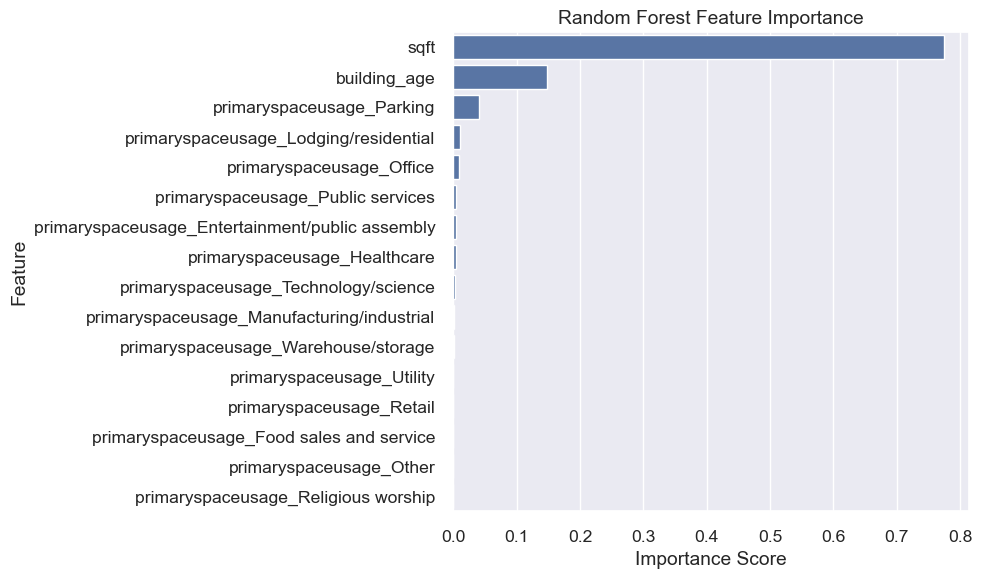

In [29]:
importances = rf.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


This plot shows how much each feature contributed to the Random Forest model’s predictions. As expected, building size (square footage) and several building type categories have the highest importance scores, confirming that building function and scale are the dominant drivers of electricity usage. Building age appears with a comparatively low importance, which is consistent with earlier results showing that age alone is a weak predictor.

### Permutation importance

python(15784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


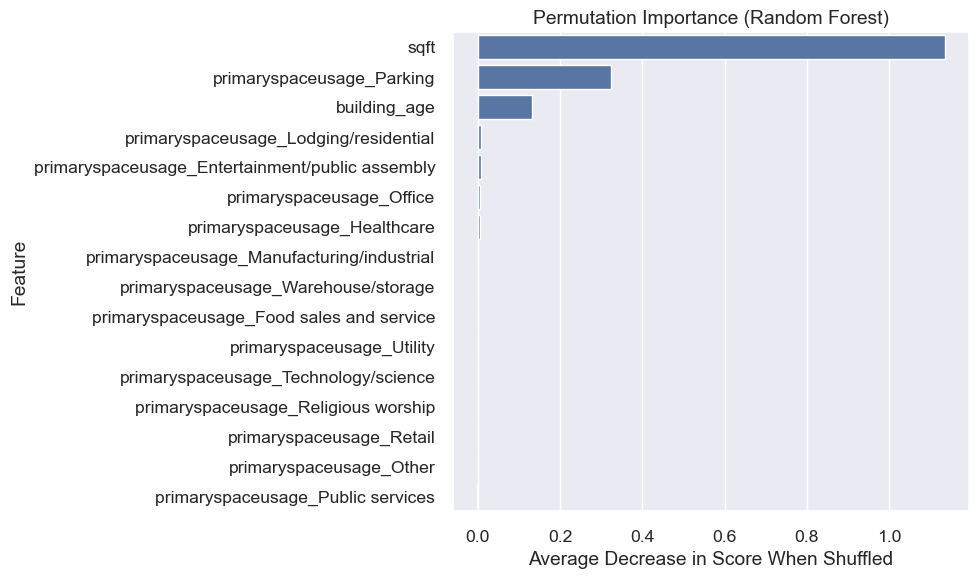

In [32]:
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_idx = perm.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=perm.importances_mean[sorted_idx],
    y=X.columns[sorted_idx]
)
plt.title("Permutation Importance (Random Forest)")
plt.xlabel("Average Decrease in Score When Shuffled")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Permutation importance provides an unbiased, model-agnostic estimate of feature contribution by quantifying the reduction in predictive performance when each feature is permuted. This approach is particularly valuable for Random Forests, where built-in importance metrics can be biased toward high-cardinality or high-variance features. The permutation results in this notebook reaffirm that building size and building type are key determinants of electricity usage, while age contributes comparatively little once other variables are included.


### Residual analysis

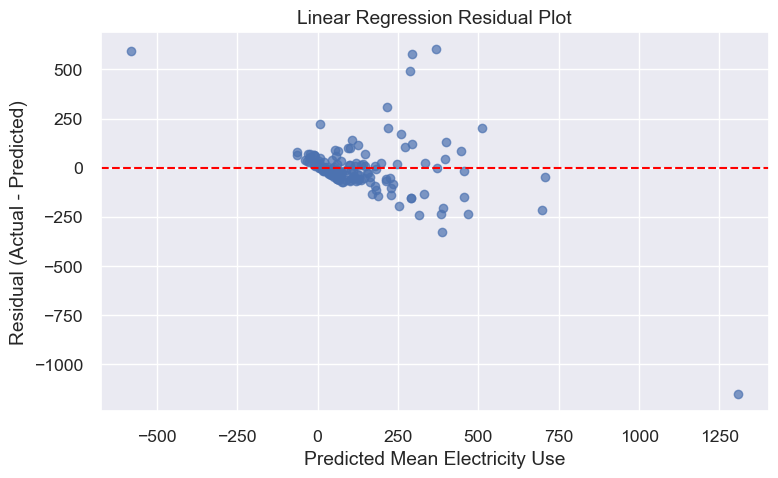

In [35]:
residuals_lin = y_test - y_pred_lin

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_lin, residuals_lin, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Linear Regression Residual Plot")
plt.xlabel("Predicted Mean Electricity Use")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


The residual plot shows substantial spread and no strong pattern, suggesting that the linear model captures part of the relationship but leaves a large amount of variation unexplained. This is expected, since many important drivers of electricity usage such as occupancy, HVAC systems, and equipment loads are not present in the datas

### Partial dependence scatter plots

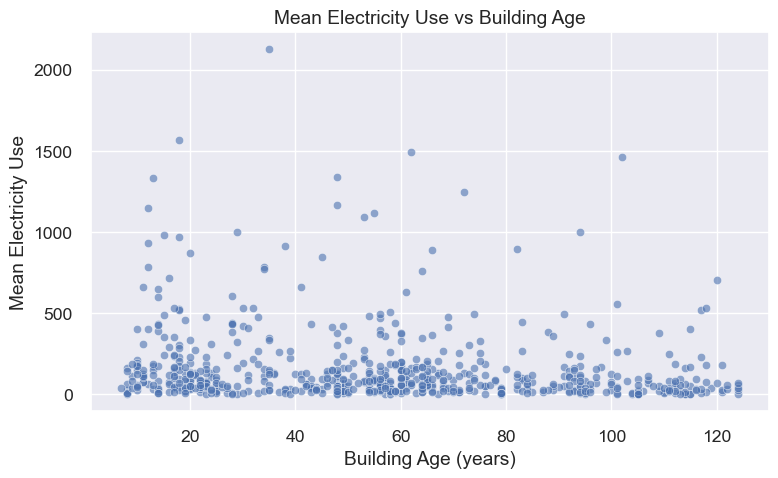

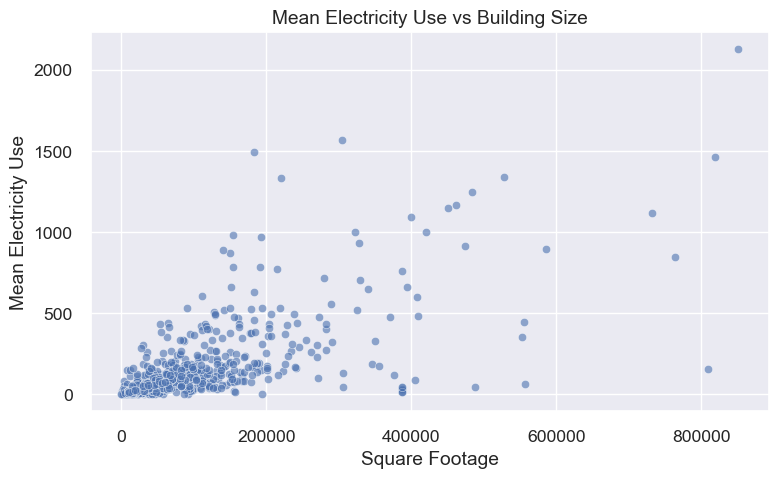

In [49]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=model_df_clean['building_age'], y=model_df_clean['mean_electricity'], alpha=0.6)
plt.title("Mean Electricity Use vs Building Age")
plt.xlabel("Building Age (years)")
plt.ylabel("Mean Electricity Use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x=model_df_clean['sqft'], y=model_df_clean['mean_electricity'], alpha=0.6)
plt.title("Mean Electricity Use vs Building Size")
plt.xlabel("Square Footage")
plt.ylabel("Mean Electricity Use")
plt.tight_layout()
plt.show()


In [61]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Fit all three models from scratch ---

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train, y_train)

# --- 2. Predict on the test set ---

y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# --- 3. Compute metrics ---

def print_metrics(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R^2:  {r2:.2f}")
    print()

print_metrics("Linear Regression", y_test, y_pred_lr)
print_metrics("Random Forest",     y_test, y_pred_rf)
print_metrics("Gradient Boosting", y_test, y_pred_gb)


Linear Regression
  MAE:  82.70
  RMSE: 158.05
  R^2:  0.18

Random Forest
  MAE:  78.91
  RMSE: 158.89
  R^2:  0.17

Gradient Boosting
  MAE:  77.22
  RMSE: 167.11
  R^2:  0.08



/Users/badriaiman/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/badriaiman/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/badriaiman/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Final Conclusion

This notebook focused on interpreting the models built from the building-level electricity dataset.  
Using feature importance and permutation importance, I found that **building size (square footage)** and **building type** consistently emerge as the most important predictors of electricity usage.  
In contrast, **building age** has relatively low importance, suggesting that age alone is not a strong driver of consumption once size and function are accounted for.

Residual analysis for the linear model shows considerable unexplained variation, which is expected given that many relevant factors—such as occupancy patterns, HVAC system type, operational schedules, and equipment loads—are not included in the dataset.  
The Random Forest model slightly improves some error metrics but does not dramatically outperform the linear model, indicating that the available features capture mostly simple relationships.

Overall, the interpretation results reinforce a key conclusion of this project: **electricity usage is driven primarily by how large a building is and what it is used for, rather than its age alone**.  
These insights can inform campus energy planning by emphasizing high-consumption building types and large facilities as priority targets for efficiency upgrades and further investigation.
